In [1]:
!pip install newspaper3k
!pip install pandas
!pip install matplotlib
!pip install transformers
!pip install nltk
!pip install sentencepiece
!pip install wordpiece
!pip install ipywidgets
!pip install -U scikit-learn
!pip install tqdm
!pip install pydot
# using nvidia-docker image from https://ngc.nvidia.com/catalog/containers/nvidia:tensorflow/tags
# using release 21.02-tf2-py3"

     |████████████████████████████████| 211 kB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 7.4 MB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 6.7 MB/s eta 0:00:011
     |████████████████████████████████| 87 kB 5.2 MB/s eta 0:00:011
     |████████████████████████████████| 115 kB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 5.4 MB 6.2 MB/s eta 0:00:01
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13537 sha256=bebd3b7c81c068c2a36c321367a2b8810376c9ebb6bc81e00254ce56f1accf5c
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c09
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3354 sha256=e546ee97d1eb7f10b452160068aecefa8c702c578ce13e0f2b7035f62cbec640
  Stored in directory: /root/.cache/pip/wheels/b6/09/68/a9f15498ac02c23dde29f18745bc6a6f574ba4ab

In [2]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# from transformers import BertTokenizer, TFBertModel

In [6]:
from transformers import BertTokenizer, TFBertForMultipleChoice, TFBertForSequenceClassification, TFBertModel

# Data Exploration

In [7]:
train_section = pd.read_table("train_dataset.csv", sep='\t', index_col=0)
val_section = pd.read_table("val_dataset.csv", sep='\t', index_col=0)
test_section = pd.read_table("test_dataset.csv", sep='\t', index_col=0)

## Hyperparameters

In [8]:
MAX_LEN = 512
nepochs = 25
nbatch = 5

In [9]:
data_dir = "./data"
log_dir = f"{data_dir}/experiments/logs"
save_path = f"{data_dir}/experiments/BinaryBERTmodels"
cache_path_train = f"{data_dir}/cache/BinaryBERTmodel.train"
cache_path_test = f"{data_dir}/cache/BinaryBERTmodel.test"

## Transforming Data

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = np.asarray(le.fit_transform(train_section['label']))
val_labels = np.asarray(le.transform(val_section['label']))
# train_labels = np.asarray(train_section['label'])
# val_labels = np.asarray(val_section['label'])

# train_labels = np.asarray(train_section['democrat.bias']+1)
# val_labels = np.asarray(val_section['democrat.bias']+1)

In [11]:
# le.inverse_transform(val_labels)[:20]

In [12]:
len(np.unique(train_labels))

2

In [13]:
tokenizer_transformer = BertTokenizer.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
# Initialise Bert Tokenizer

def create_input_array(df, tokenizer):
    sentences = df.text.values

    input_ids = []
    attention_masks = []
    token_type_ids = []

    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=MAX_LEN,  # Pad & truncate all sentences.
                pad_to_max_length=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors='tf',  # Return tf tensors.
            )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

        token_type_ids.append(encoded_dict['token_type_ids'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    token_type_ids = tf.convert_to_tensor(token_type_ids)


    return input_ids, attention_masks, token_type_ids



In [15]:
train_inputs = [create_input_array(train_section, tokenizer=tokenizer_transformer)]
val_inputs = [create_input_array(val_section, tokenizer=tokenizer_transformer)]

# train_inputs = [create_input_array(list(train_section["text"]), tokenizer=bert_tokenizer_transformer)]
# val_inputs = [create_input_array(list(val_section["text"]), tokenizer=bert_tokenizer_transformer)]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
def convert_inputs_to_tf_dataset(inputs):
    # args.max_seq_len = 256
    ids = inputs[0][0]
    masks = inputs[0][1]
    token_types = inputs[0][2]

    ids = tf.reshape(ids, (-1, MAX_LEN))
    print("Input ids shape: ", ids.shape)
    masks = tf.reshape(masks, (-1, MAX_LEN))
    print("Input Masks shape: ", masks.shape)
    token_types = tf.reshape(token_types, (-1, MAX_LEN))
    print("Token type ids shape: ", token_types.shape)

    ids=ids.numpy()
    masks = masks.numpy()
    token_types = token_types.numpy()

    return [ids, masks, token_types]

In [17]:
train_data = convert_inputs_to_tf_dataset(train_inputs)
val_data = convert_inputs_to_tf_dataset(val_inputs)

Input ids shape:  (4000, 512)
Input Masks shape:  (4000, 512)
Token type ids shape:  (4000, 512)
Input ids shape:  (500, 512)
Input Masks shape:  (500, 512)
Token type ids shape:  (500, 512)


In [18]:
train_data

[array([[  101,  2899,  1516, ...,  2216,  2024,   102],
        [  101,  2022,  4783, ...,  2000,  5865,   102],
        [  101,  2160, 10643, ...,  3513,  1010,   102],
        ...,
        [  101,  2899,  1011, ...,  2478, 11744,   102],
        [  101,  3120,  2048, ..., 18079,  2003,   102],
        [  101,  4092,  1999, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)]

In [19]:
val_section[val_section['label']=='Neutral'].shape[0]/val_section.article.shape[0]

0.546

In [20]:
model = TFBertForSequenceClassification.from_pretrained('bert-large-uncased',num_labels=len(np.unique(train_labels)))

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  335141888 
_________________________________________________________________
dropout_73 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2050      
Total params: 335,143,938
Trainable params: 335,143,938
Non-trainable params: 0
_________________________________________________________________


In [22]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-07, epsilon=1e-08)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(x = train_data, 
          y = train_labels,
          validation_data= (val_data, val_labels), 
          epochs = 25, 
          batch_size = 5)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 335s 399ms/step - loss: 0.7060 - accuracy: 0.4931 - val_loss: 0.6861 - val_accuracy: 0.5880
Epoch 2/25
800/800 [==============================] - 322s 403ms/step - loss: 0.6897 - accuracy: 0.5486 - val_lo

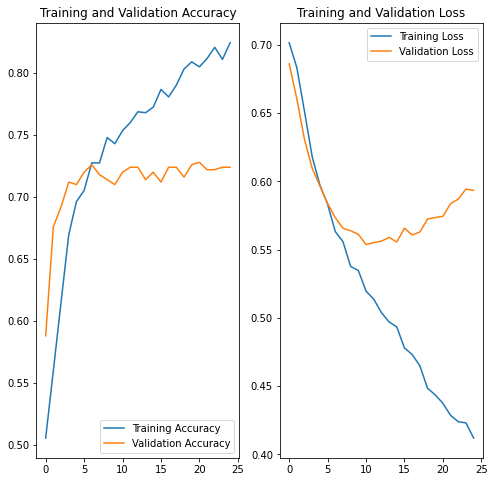

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.show()
plt.savefig('bertlargebinary.jpg')

In [24]:
bertmodeldata = pd.DataFrame(list(zip(acc, val_acc, loss, val_loss)),
               columns =['Accuracy', 'ValAccuracy', 'Loss', 'Val_loss'])
bertmodeldata.head()

,Accuracy,ValAccuracy,Loss,Val_loss
0,0.50550,0.588,0.701568,0.686063
1,0.56000,0.676,0.683247,0.660316
2,0.61500,0.692,0.651001,0.630535
3,0.66950,0.712,0.617953,0.609455
4,0.69625,0.710,0.597174,0.596540


In [25]:
bertmodeldata.to_csv("bertmodeldata.csv", sep='\t')

In [27]:
test_section.shape

(110, 16)

In [28]:
test_labels = np.asarray(le.transform(test_section['label']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer)]
test_data = convert_inputs_to_tf_dataset(test_inputs)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Input ids shape:  (110, 512)
Input Masks shape:  (110, 512)
Token type ids shape:  (110, 512)


In [37]:
print("Evaluate on test data")
results = model.evaluate(test_data, test_labels, batch_size=5)
print("test loss, test acc:", results)


Evaluate on test data
22/22 [==============================] - 2s 112ms/step - loss: 0.5406 - accuracy: 0.7455
test loss, test acc: [0.5405929088592529, 0.7454545497894287]


In [29]:
# predict probabilities for test set
test_probs = model.predict(test_data, batch_size= 1, verbose=0)

In [31]:
test_probs = model.predict(test_data, batch_size= 1, verbose=0)

In [30]:
test_probs = test_probs["logits"]

In [31]:
test_classes = np.argmax(test_probs, axis = 1)

In [32]:
test_classes

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0])

In [33]:
test_labels

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [34]:
c=0
for i in range(test_classes.shape[0]):
    if test_classes[i]==test_labels[i]:
        c+=1
print("Test accuracy:")
print(c/test_labels.shape[0])

Test accuracy:
0.7454545454545455


In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [36]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, test_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, test_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, test_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, test_classes)
print('F1 score: %f' % f1)
 

Accuracy: 0.745455
Precision: 0.742857
Recall: 0.838710
F1 score: 0.787879


In [39]:
train_section.to_csv("train_dataset.csv", sep='\t')
val_section.to_csv("val_dataset.csv", sep='\t')
test_section.to_csv("test_dataset.csv", sep='\t')

In [26]:
model.save_pretrained(save_path)

In [77]:
tf.keras.backend.clear_session()